# This notebook shows how to use Hamilton as a Feature Catalog

In [1]:
import logging
import sys

logging.basicConfig(stream=sys.stdout)

%load_ext autoreload
%autoreload 2

# What is a Feature Catalog

It is a place (Python package) to centrally make transformation logic avaialable for feature pipelines.

It is NOT a feature store. 

It only contains the transformation logic.

## What transformation logic to in/exclude?

Ideally the data that the Feature Catalog loads as input data is as mature and clean as possible.
This means that the data is organized and prepared to support various analytics use cases.

Of course, often this is not the reality in many organizations. 
Therefore, transformation logic to clean and improve the data model can be (temporarily) part of the Feature Catalog.
Ideally this transformation logic will later be migrated such that these transformations are precomputed to save time and compute for all use cases.

## Benefits
- single source of truth
- speeds up development because of easy re-use (write code + docs only once)
- increases quality because of collaboration


# Feature Catalog vs. Feature Store

<img src="feature_catalog.drawio.png" />

# How to use Hamilton as Feature Catalog

## Choices made

- Each node is a dataframe -> keeps it easy to reason about your data flows
- Each node is tagged with its schema using `@schema.output` -> to keep track of the available columns
- Four types of nodes (next to inputs and config), using `@tag(data_type="...")`:
    - Raw -> just load data from source
    - Intermediate -> any intermediate table
    - Features -> table with features; one row per entity (e.g. customer)
    - Optional -> only created based on a config setting

## Benefits

1. The DAG gives a good overview to understand what is possible
2. Users can easily re-use both features and intermediate logic
3. Makes it easy to debug your data flows by easy access to all intermediate nodes/dataframes
4. It can support many different use cases by providing flexibility in the form of:
    - A: config (to influence the shape of the DAG)
    - B: inputs (such as boolean options or filter experessions)
    - C: overrides (to replace parts of the pipeline)


## Challenge

- Keep the logic manageble and easy to use
    - too much flexibility causes complexity; it is a trade-off

# Example: Supermarket Transaction Data 

## 1. The DAG gives a good overview to understand what is possible

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from main import get_driver, custom_style_function

spark = SparkSession.builder.master("local[1]").getOrCreate()

/home/jovyan/.local/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


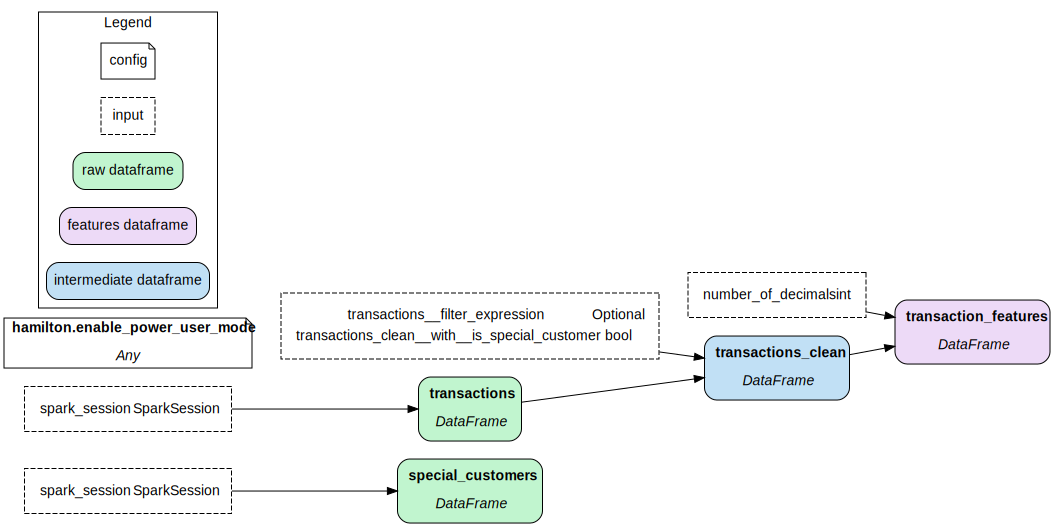

In [3]:
config = {"transactions_clean__with__is_special_customer": False}
dr = get_driver(config)
dr.display_all_functions(show_schema=False, custom_style_function=custom_style_function)

## 2. Users can easily re-use both features and intermediate logic

In [4]:
# We can easily access the `transactions_clean` or `transaction_features` dataframes
inputs = {
    "spark_session": spark,
    "number_of_decimals": 2,
}

result = dr.execute(
    final_vars=["transactions_clean", "transaction_features"], 
    inputs=inputs,
)
transactions_clean = result["transactions_clean"]
transaction_features = result["transaction_features"]

transactions_clean.show(5), transaction_features.show(5)

+--------------+-------------------+-----------+-----------+---------+---------------+------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+
|          4335|2023-01-01 11:25:52|       3650|       4617|   354.01|          41152|           0|
|         17517|2023-01-02 17:14:06|       1495|       6739|   712.24|         148446|           1|
|         28840|2023-01-04 00:17:17|       3319|       7550|   796.77|         260237|           3|
|         36777|2023-01-04 17:08:02|       1639|       1863|   375.86|         320882|           3|
|         37469|2023-01-04 19:01:04|       4905|       8872|    698.3|         327664|           3|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+
only showing top 5 rows

+-----------+-------------+--------------+----------------+
|customer_id|su

(None, None)

## 3. Makes it easy to debug your data flows by easy access to all intermediate nodes/dataframes

Note how the example above makes it easy to quickly inspect the `transactions_clean` which are the input for the `transaction_features`

## 4. It can support many different use cases by providing flexibility in the form of:
### A: config (to influence the shape of the DAG)

E.g., based on a config setting, extend a node with a column (which needs to load additional raw data).

Scenario 1 (config to False): `special_customers` data is not used

Scenario 2 (config to True): `special_customers` data is used to add a column `is_special_customer` to `transactions_clean`

*NOTE: to influence the DAG and also dynamically determine the correct schemas we make use of advanced Hamilton functionality (@resolve)*

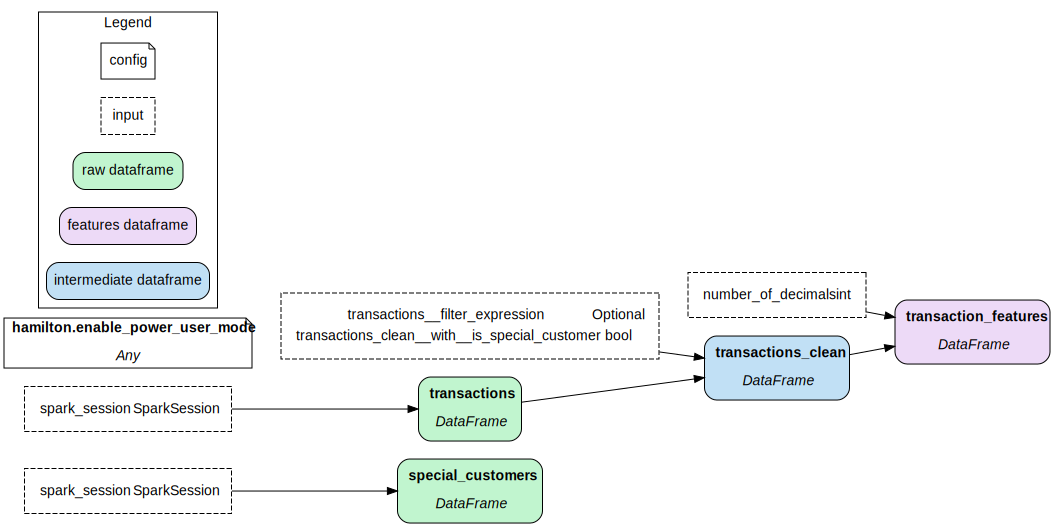

In [5]:
# Scenario 1: config to False
config = {"transactions_clean__with__is_special_customer": False}
dr = get_driver(config)
display(dr.display_all_functions(show_schema=False, custom_style_function=custom_style_function))

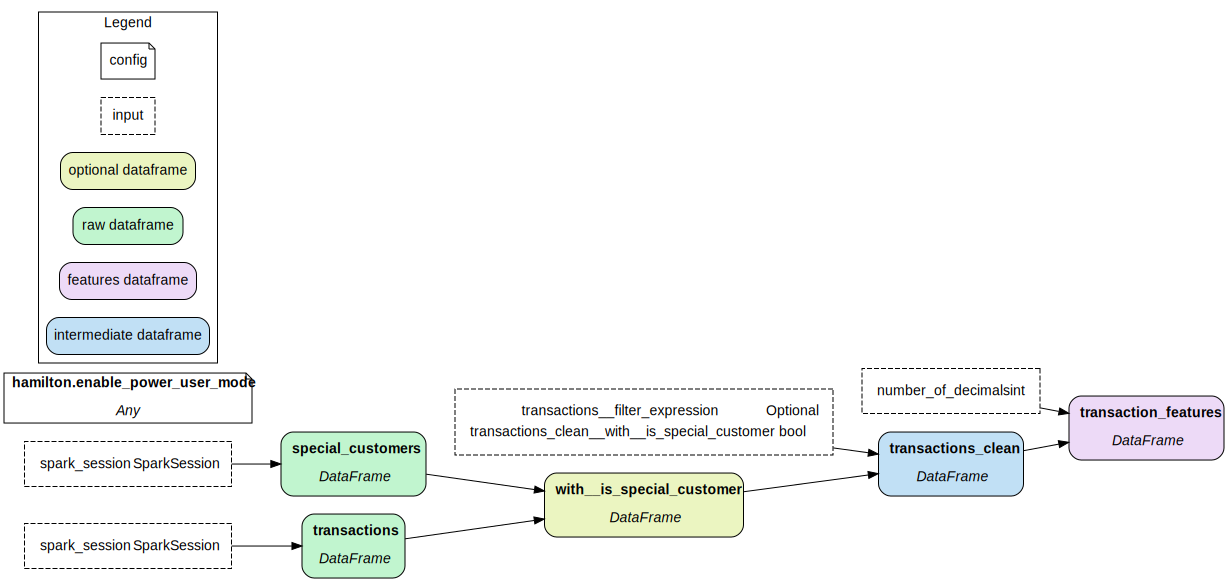

In [6]:
# Scenario 2: config to True
config = {"transactions_clean__with__is_special_customer": True}
dr = get_driver(config)
display(dr.display_all_functions(show_schema=False, custom_style_function=custom_style_function))

## 4. It can support many different use cases by providing flexibility in the form of:
### B: inputs (such as boolean options or filter experessions)

Influence the content of `transactions_clean` by filtering only the transactions from `special_customers` using the optional input `transactions__filter_expression`

*NOTE: inputs is a basic Hamilton functionality*

In [7]:
inputs = {
    "spark_session": spark,
    "transactions__filter_expression": F.col("is_special_customer") == True
}

result = dr.execute(
    final_vars=["transactions_clean"], 
    inputs=inputs,
)
transactions_clean = result["transactions_clean"]
transactions_clean.show()

+--------------+-------------------+-----------+-----------+---------+---------------+------------+-------------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|is_special_customer|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+-------------------+
|          4335|2023-01-01 11:25:52|       3650|       4617|   354.01|          41152|           0|               true|
|         17517|2023-01-02 17:14:06|       1495|       6739|   712.24|         148446|           1|               true|
|         28840|2023-01-04 00:17:17|       3319|       7550|   796.77|         260237|           3|               true|
|         36777|2023-01-04 17:08:02|       1639|       1863|   375.86|         320882|           3|               true|
|         37469|2023-01-04 19:01:04|       4905|       8872|    698.3|         327664|           3|               true|
|         38098|2023-01-04 21:47:00|    

## 4. It can support many different use cases by providing flexibility in the form of:
### C: overrides (to replace parts of the pipeline)

Override `transactions_clean` with a modified version where all amounts are divided by one million.

*NOTE: overrides is a basic Hamilton functionality*

In [8]:
inputs = {"number_of_decimals": 3}
overrides = {"transactions_clean": transactions_clean.withColumn("tx_amount", F.col("tx_amount") / 1_000_000)}

result = dr.execute(
    final_vars=["transaction_features"], 
    inputs=inputs,
    overrides=overrides,
)
transaction_features = result["transaction_features"]
transaction_features.show()

+-----------+-------------+--------------+----------------+
|customer_id|sum_tx_amount|mean_tx_amount|median_tx_amount|
+-----------+-------------+--------------+----------------+
|       2052|          0.0|           0.0|             0.0|
|       3650|          0.0|           0.0|             0.0|
|       3648|        0.001|         0.001|           0.001|
|       4905|        0.001|         0.001|           0.001|
|       3319|        0.001|         0.001|           0.001|
|       1495|        0.001|         0.001|           0.001|
|       4163|          0.0|           0.0|             0.0|
|       1639|          0.0|           0.0|             0.0|
|       1472|        0.001|         0.001|           0.001|
|       1328|        0.001|         0.001|           0.001|
+-----------+-------------+--------------+----------------+

